# 1. Set up and load the data

In [1]:
# Imports.

import time
from functools import partial
from multiprocessing import Pool, cpu_count, shared_memory
from typing import Dict, Optional, Tuple

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm

In [2]:
# Define dataset name.

DATASET = 'adamson_2016_pilot_curated'
# DATASET = 'adamson_2016_upr_epistasis_curated'
# DATASET = 'adamson_2016_upr_perturb_seq_curated'
# DATASET = 'datlinger_2017_curated'
# DATASET = 'orion_2025_hct116_curated'
# DATASET = 'orion_2025_hek293t_curated'

In [3]:
# Copy dataset from storage.

# ! gsutil cp gs://perturbation-catalogue-lake/perturbseq/curated/{DATASET}.h5ad {DATASET}.h5ad

Copying gs://perturbation-catalogue-lake/perturbseq/curated/adamson_2016_pilot_curated.h5ad...
- [1 files][117.1 MiB/117.1 MiB]                                                
Operation completed over 1 objects/117.1 MiB.                                    


In [4]:
# Load the h5ad file.

adata = sc.read_h5ad(f'{DATASET}.h5ad', backed="r")

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# FIX: adata.var index structure.

adata.var.drop(columns=['gene_symbol'], inplace=True)
adata.var.index.name = 'gene_symbol'
adata.var.reset_index(inplace=True)
adata.var.set_index('gene_symbol', inplace=True)
adata.var['gene_symbol'] = adata.var.index

In [6]:
# FIX: downsample controls.

adata.obs['perturbed_target_symbol'] = adata.obs['perturbed_target_symbol'].str.replace(r'^control.*', 'control', regex=True).astype("category")

# 2. Data investigations

In [7]:
# Check that any given row can be quickly accessed.

adata.X[42]

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2433 stored elements and shape (1, 35635)>

In [8]:
# Overview of the file.

adata

AnnData object with n_obs × n_vars = 5752 × 35635 backed at 'adamson_2016_pilot_curated.h5ad'
    obs: 'perturbation_name', 'perturbed_target_coord', 'perturbed_target_number', 'perturbed_target_ensg', 'perturbed_target_symbol', 'perturbed_target_biotype', 'guide_sequence', 'perturbation_type_label', 'perturbation_type_id', 'timepoint', 'treatment_label', 'treatment_id', 'model_system_label', 'model_system_id', 'species', 'tissue_label', 'tissue_id', 'cell_type_label', 'cell_type_id', 'cell_line_label', 'cell_line_id', 'sex_label', 'sex_id', 'developmental_stage_label', 'developmental_stage_id', 'disease_label', 'disease_id'
    var: 'ensembl_gene_id', 'gene_symbol'

In [9]:
# High level look at the observations.

adata.obs

,perturbation_name,perturbed_target_coord,perturbed_target_number,perturbed_target_ensg,perturbed_target_symbol,perturbed_target_biotype,guide_sequence,perturbation_type_label,perturbation_type_id,timepoint,...,cell_type_label,cell_type_id,cell_line_label,cell_line_id,sex_label,sex_id,developmental_stage_label,developmental_stage_id,disease_label,disease_id
0,CREB1_pDS269,chr2:207529737-207605988;1,1,ENSG00000118260,CREB1,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
1,SNAI1_pDS266,chr20:49982980-49988886;1,1,ENSG00000124216,SNAI1,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
2,62(mod)_pBA581,NaN,1,control_nontargeting,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
3,EP300_pDS268,chr22:41092510-41180077;1,1,ENSG00000100393,EP300,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
4,62(mod)_pBA581,NaN,1,control_nontargeting,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5747,SNAI1_pDS266,chr20:49982980-49988886;1,1,ENSG00000124216,SNAI1,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
5748,SNAI1_pDS266,chr20:49982980-49988886;1,1,ENSG00000124216,SNAI1,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
5749,SNAI1_pDS266,chr20:49982980-49988886;1,1,ENSG00000124216,SNAI1,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
5750,62(mod)_pBA581,NaN,1,control_nontargeting,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996


In [10]:
# High level look at the genes.

adata.var

,ensembl_gene_id,gene_symbol
gene_symbol,,
MIR1302-10,ENSG00000243485,MIR1302-10
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
RP11-34P13.7,ENSG00000238009,RP11-34P13.7
RP11-34P13.8,ENSG00000239945,RP11-34P13.8
...,...,...
MT-ND4L,ENSG00000212907,MT-ND4L
MT-ND4,ENSG00000198886,MT-ND4
MT-ND5,ENSG00000198786,MT-ND5


# 3. Perturbed genes statistics

Total number of distinct perturbed genes: 7
First 10 perturbed genes: ['CREB1', 'SNAI1', 'EP300', 'ZNF326', 'BHLHE40', 'SPI1', 'DDIT3']


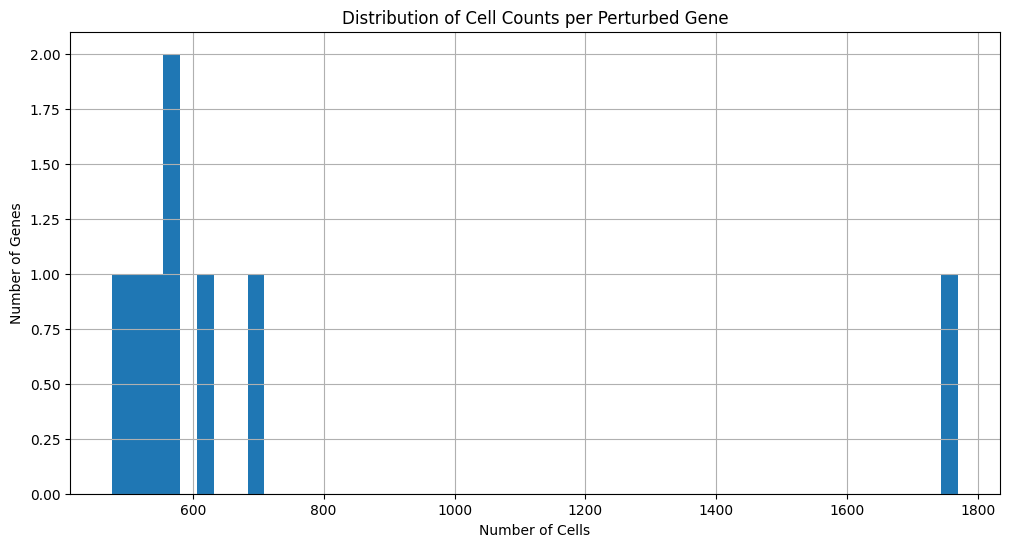


Statistics of cells per perturbed gene:
count       8.000000
mean      719.000000
std       429.780675
min       477.000000
25%       541.250000
50%       559.500000
75%       648.000000
max      1769.000000
Name: count, dtype: float64


In [11]:
# Get all unique perturbation targets (including 'control')
all_targets = adata.obs['perturbed_target_symbol'].unique()

# Filter out 'control' to get only perturbed genes
perturbed_targets = [t for t in all_targets if t != 'control']
num_perturbed_genes = len(perturbed_targets)

print(f"Total number of distinct perturbed genes: {num_perturbed_genes}")
print("First 10 perturbed genes:", perturbed_targets[:10])

# Count number of cells per perturbed gene
target_counts = adata.obs['perturbed_target_ensg'].value_counts()

# Remove 'control' from the counts for plotting
perturbation_counts = target_counts[target_counts.index != 'control']

# Plot histogram
plt.figure(figsize=(12, 6))
perturbation_counts.hist(bins=50)
plt.title('Distribution of Cell Counts per Perturbed Gene')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.grid(True)
plt.show()

# Show some statistics
print("\nStatistics of cells per perturbed gene:")
print(perturbation_counts.describe())

# 4. Cell type statistics

Total number of distinct cell types: 1
All cell types: ['lymphoblast']
Categories (1, object): ['lymphoblast']


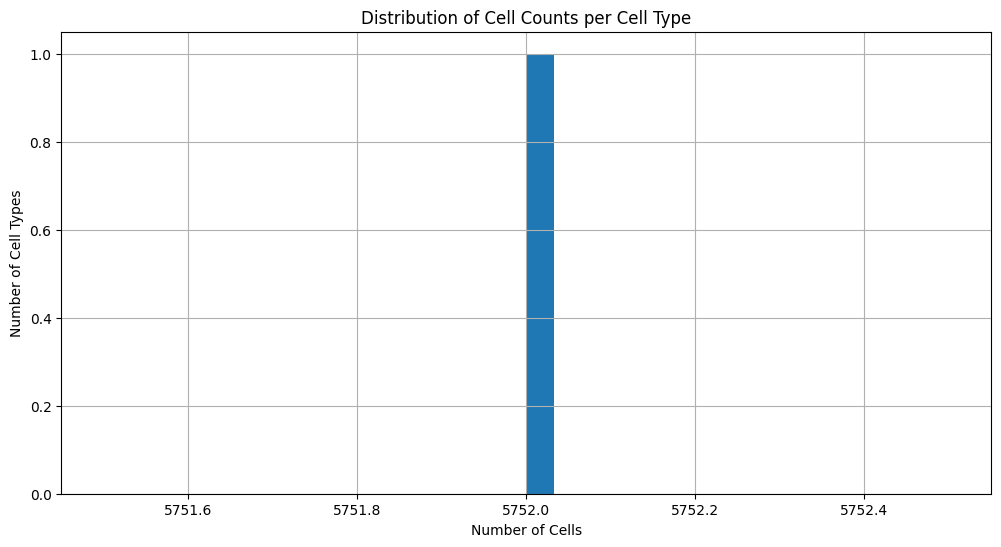

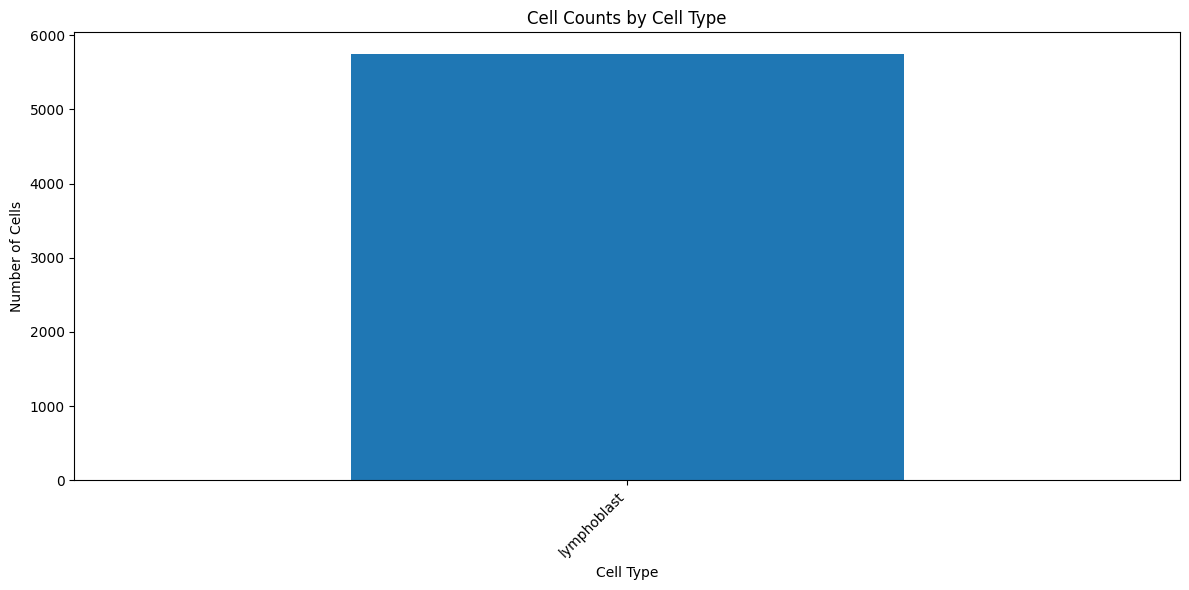


Statistics of cells per cell type:
count       1.0
mean     5752.0
std         NaN
min      5752.0
25%      5752.0
50%      5752.0
75%      5752.0
max      5752.0
Name: count, dtype: float64

Complete cell type distribution:
cell_type_label
lymphoblast    5752
Name: count, dtype: int64


In [12]:
# Get all unique cell types
cell_types = adata.obs['cell_type_label'].unique()
num_cell_types = len(cell_types)

print(f"Total number of distinct cell types: {num_cell_types}")
print("All cell types:", cell_types)

# Count number of cells per cell type
cell_type_counts = adata.obs['cell_type_label'].value_counts()

# Plot histogram
plt.figure(figsize=(12, 6))
cell_type_counts.hist(bins=30)
plt.title('Distribution of Cell Counts per Cell Type')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Cell Types')
plt.grid(True)
plt.show()

# Plot as bar chart for better readability
plt.figure(figsize=(12, 6))
cell_type_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Cell Counts by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show some statistics
print("\nStatistics of cells per cell type:")
print(cell_type_counts.describe())

# Show the complete distribution
print("\nComplete cell type distribution:")
print(cell_type_counts)

# 5. Levels of expression of control genes

# 6. Pseudobulk differential expression

In [13]:
import pandas as pd
import numpy as np
import time
from anndata import AnnData
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
from collections import defaultdict
import os

def compute_pseudobulk_perturbation_analysis(
    adata: AnnData,
    output_csv_path: str,
    perturbation_col: str = "perturbed_target_symbol",
    cell_type_col: str = "cell_type_label",
    control_label: str = "control",
    min_cells_per_group: int = 10,
    log_transform: bool = True,
    chunk_size: int = 10000,
    min_expression_threshold: float = 10.0,
    debug_chunks: int = None,
    debug_perturbations: int = None
) -> None:
    """
    Compute pseudobulk analysis for perturbation data using a single-pass, chunked
    approach, streaming results directly to a file to handle large datasets.

    This function iterates through the data once to compute summary statistics
    (count, sum, and sum of squares) for each perturbation group stratified by cell type.
    It then calculates differential expression and writes the results to a CSV file,
    avoiding high memory usage.

    Parameters:
    -----------
    adata : AnnData
        Annotated data object with perturbation expression results, ideally in backed mode.
    output_csv_path : str
        Path to the output CSV file where results will be saved.
    perturbation_col : str
        Column name in adata.obs containing perturbation target symbols.
    cell_type_col : str
        Column name in adata.obs containing cell type or cell line labels.
    control_label : str
        Label used for control/non-targeting samples.
    min_cells_per_group : int
        Minimum number of cells required per perturbation group within each cell type.
    log_transform : bool
        Whether to log1p-transform the data before analysis. The function will attempt
        to automatically skip transformation if data appears to be already logged.
    chunk_size : int
        Number of cells to process in each chunk during the single pass.
    min_expression_threshold : float
        Minimum total pseudobulk control expression to include a gene in the analysis.
    debug_chunks : int, optional
        If set, process only the first N chunks for quick debugging. Defaults to None.
    debug_perturbations : int, optional
        If set, process only the first N perturbations per cell type. Defaults to None.

    Returns:
    --------
    None
        Results are saved directly to the specified CSV file.
    """
    start_time = time.time()
    print("🚀 Starting single-pass pseudobulk analysis...")

    # --- 1. Initial validation and setup ---
    if perturbation_col not in adata.obs.columns:
        raise ValueError(f"Perturbation column '{perturbation_col}' not found in adata.obs")
    if cell_type_col not in adata.obs.columns:
        raise ValueError(f"Cell type column '{cell_type_col}' not found in adata.obs")

    # --- 2. Pre-computation: Find valid groups and initialize stats storage ---
    print("📊 Pre-processing: Identifying valid cell type/perturbation groups...")
    obs_filtered = adata.obs.dropna(subset=[perturbation_col])
    
    group_counts = obs_filtered.groupby([cell_type_col, perturbation_col]).size()
    valid_groups = group_counts[group_counts >= min_cells_per_group].index
    
    if not any(control_label in pert for _, pert in valid_groups):
        raise ValueError(f"Control label '{control_label}' not found in any group meeting the minimum cell threshold.")

    stats_dict = defaultdict(dict)
    for cell_type, pert in valid_groups:
        stats_dict[cell_type][pert] = {
            'n': group_counts.loc[(cell_type, pert)],
            'sum_x': np.zeros(adata.n_vars, dtype=np.float64),
            'sum_x_sq': np.zeros(adata.n_vars, dtype=np.float64)
        }
    
    print(f"  ✓ Found {len(valid_groups)} valid groups meeting the {min_cells_per_group} cell threshold.")

    # --- 3. Single-Pass Data Aggregation ---
    print("\n🏎️  Performing single pass over the data to collect statistics...")
    if debug_chunks is not None:
        print(f"⚠️ [DEBUG MODE] Will process a maximum of {debug_chunks} chunk(s).")

    is_log_transformed = not log_transform
    first_chunk_X = adata.X[:min(chunk_size, adata.n_obs), :]
    if log_transform and np.max(first_chunk_X) > 20:
        print("  ✓ Detected high expression values. Applying log1p transformation.")
        is_log_transformed = True
    else:
        print("  ✓ Data appears to be already logged or log_transform=False. Skipping transformation.")

    chunk_counter = 0
    for start in tqdm(range(0, adata.n_obs, chunk_size), desc="Processing Chunks", unit="chunk"):
        if debug_chunks is not None and chunk_counter >= debug_chunks:
            print(f"\n[DEBUG] Processed the first {debug_chunks} chunks. Halting data aggregation.")
            break

        end = min(start + chunk_size, adata.n_obs)
        obs_chunk = adata.obs.iloc[start:end]
        
        # Ensure the loaded chunk is a standard numpy ndarray to avoid shape issues
        # with np.matrix objects, which can result from .toarray()
        expression_data = adata.X[start:end, :]
        if hasattr(expression_data, 'toarray'):
            X_chunk = np.asarray(expression_data.toarray())
        else:
            X_chunk = np.asarray(expression_data)
        
        if is_log_transformed:
            X_chunk = np.log1p(X_chunk)

        chunk_index = obs_chunk.index
        for (cell_type, pert), group_indices in obs_chunk.groupby([cell_type_col, perturbation_col], observed=False).groups.items():
            if (cell_type, pert) in valid_groups:
                local_indices = chunk_index.get_indexer(group_indices)
                if np.any(local_indices == -1): continue
                
                X_group_chunk = X_chunk[local_indices, :]
                
                # These sums will now correctly produce 1D arrays
                stats_dict[cell_type][pert]['sum_x'] += np.sum(X_group_chunk, axis=0)
                stats_dict[cell_type][pert]['sum_x_sq'] += np.sum(np.square(X_group_chunk), axis=0)
        
        chunk_counter += 1

    # --- 4. Post-Pass Calculation and Output ---
    print("\n🔬 All statistics collected. Calculating differential expression...")
    print(f"📦 Streaming results directly to: {output_csv_path}")
    
    output_dir = os.path.dirname(output_csv_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    analyzed_cell_types = set()
    analyzed_perturbations = set()
    total_comparisons = 0

    with open(output_csv_path, 'w') as f_out:
        header = "cell_type_label,perturbation,gene,log2fc,pvalue,padj,mean_control,mean_perturbed\n"
        f_out.write(header)
        
        for cell_type, pert_stats in stats_dict.items():
            if control_label not in pert_stats:
                print(f"  ⚠️ Skipping {cell_type}: control group not found or did not meet cell threshold.")
                continue
            
            print(f"\n--- Analyzing {cell_type} ---")
            
            control_stats = pert_stats[control_label]
            n_control = control_stats['n']
            
            threshold_to_use = np.log1p(min_expression_threshold) if is_log_transformed else min_expression_threshold
            expressed_genes_mask = control_stats['sum_x'] > threshold_to_use
            
            if not np.any(expressed_genes_mask):
                print(f"  ⚠️ No genes passed expression threshold. Skipping.")
                continue

            sum_x_c = control_stats['sum_x'][expressed_genes_mask]
            sum_x_sq_c = control_stats['sum_x_sq'][expressed_genes_mask]
            mean_c = sum_x_c / n_control
            var_c = (sum_x_sq_c - (np.square(sum_x_c) / n_control)) / (n_control - 1)
            var_c[var_c <= 0] = 1e-12 

            perturbations_to_process = sorted([p for p in pert_stats if p != control_label])
            if debug_perturbations is not None and len(perturbations_to_process) > debug_perturbations:
                print(f"  ⚠️ [DEBUG MODE] Analyzing only the first {debug_perturbations} perturbations for {cell_type}.")
                perturbations_to_process = perturbations_to_process[:debug_perturbations]

            for pert in tqdm(perturbations_to_process, desc="  Perturbations", unit="pert"):
                stats_p = pert_stats[pert]
                n_pert = stats_p['n']
                sum_x_p = stats_p['sum_x'][expressed_genes_mask]
                sum_x_sq_p = stats_p['sum_x_sq'][expressed_genes_mask]
                
                mean_p = sum_x_p / n_pert
                var_p = (sum_x_sq_p - (np.square(sum_x_p) / n_pert)) / (n_pert - 1)
                var_p[var_p <= 0] = 1e-12

                with np.errstate(divide='ignore', invalid='ignore'):
                    _, pvalues = stats.ttest_ind_from_stats(
                        mean1=mean_p, std1=np.sqrt(var_p), nobs1=n_pert,
                        mean2=mean_c, std2=np.sqrt(var_c), nobs2=n_control,
                        equal_var=False
                    )
                pvalues = np.nan_to_num(pvalues, nan=1.0)
                
                _, padj, _, _ = multipletests(pvalues, method='fdr_bh')
                
                pseudocount = 1e-8
                log2fc = np.log2((mean_p + pseudocount) / (mean_c + pseudocount))
                
                pert_results = pd.DataFrame({
                    'cell_type_label': cell_type,
                    'perturbation': pert,
                    'gene': adata.var_names[expressed_genes_mask],
                    'log2fc': log2fc,
                    'pvalue': pvalues,
                    'padj': padj,
                    'mean_control': mean_c,
                    'mean_perturbed': mean_p
                })
                
                analyzed_cell_types.add(cell_type)
                analyzed_perturbations.add(pert)
                total_comparisons += len(pert_results)

                pert_results.to_csv(f_out, header=False, index=False)

    # --- 5. Final Summary ---
    print("\n\n📋 Finalizing summary...")
    
    total_time = time.time() - start_time
    print(f"\n🎉 Analysis complete! Total time: {total_time:.2f} seconds")
    print(f"   Analyzed {len(analyzed_cell_types)} cell types")
    print(f"   Analyzed {len(analyzed_perturbations)} unique perturbations")
    print(f"   Total comparisons written to file: {total_comparisons:,}")

In [14]:
# Run the analysis

results = compute_pseudobulk_perturbation_analysis(
    adata,
    f"{DATASET}.csv",
    perturbation_col="perturbed_target_symbol",
    control_label="control",
    min_cells_per_group=10,
    chunk_size=10000,  # Process 10000 cells per chunk
    min_expression_threshold=10.0,  # Only analyze genes with control expression > 10
    # debug_chunks=100,
    # debug_perturbations=100,
)

🚀 Starting single-pass pseudobulk analysis...
📊 Pre-processing: Identifying valid cell type/perturbation groups...
  ✓ Found 8 valid groups meeting the 10 cell threshold.

🏎️  Performing single pass over the data to collect statistics...
  ✓ Detected high expression values. Applying log1p transformation.


/var/tmp/ipykernel_49810/3968514890.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = obs_filtered.groupby([cell_type_col, perturbation_col]).size()


Processing Chunks:   0%|          | 0/1 [00:00<?, ?chunk/s]


🔬 All statistics collected. Calculating differential expression...
📦 Streaming results directly to: adamson_2016_pilot_curated.csv

--- Analyzing lymphoblast ---


  Perturbations:   0%|          | 0/7 [00:00<?, ?pert/s]



📋 Finalizing summary...

🎉 Analysis complete! Total time: 7.51 seconds
   Analyzed 1 cell types
   Analyzed 7 unique perturbations
   Total comparisons written to file: 89,026


In [15]:
# Upload to Google Storage.
! gsutil -m cp {DATASET}.csv gs://perturbation-catalogue-lake/perturbseq/differential_expression/{DATASET}.csv

Copying file://adamson_2016_pilot_curated.csv [Content-Type=text/csv]...
/ [1/1 files][ 10.5 MiB/ 10.5 MiB] 100% Done                                    
Operation completed over 1 objects/10.5 MiB.                                     


# 7. Volcano plots (not currently used)

In [16]:
def plot_volcano_plot(results_df, perturbation_name, 
                     pval_threshold=0.05, fc_threshold=1.0, 
                     top_n_genes=10):
    """
    Create a volcano plot for a specific perturbation.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from compute_pseudobulk_perturbation_analysis
    perturbation_name : str
        Name of the perturbation to plot
    pval_threshold : float
        P-value threshold for significance
    fc_threshold : float
        Fold change threshold (absolute log2 fold change)
    top_n_genes : int
        Number of top genes to label
    """
    import matplotlib.pyplot as plt
    
    # Filter for specific perturbation
    pert_data = results_df[results_df['perturbation'] == perturbation_name].copy()
    
    if len(pert_data) == 0:
        print(f"No data found for perturbation: {perturbation_name}")
        print(f"Available perturbations: {results_df['perturbation'].unique()}")
        return
    
    # Remove rows with NaN values for plotting
    pert_data = pert_data.dropna(subset=['padj', 'log2fc'])
    
    if len(pert_data) == 0:
        print(f"No valid data points for perturbation: {perturbation_name} after removing NaN values")
        return
    
    print(f"Plotting {len(pert_data)} genes for {perturbation_name}")
    
    # Create significance categories
    pert_data['significant'] = (pert_data['padj'] < pval_threshold) & (np.abs(pert_data['log2fc']) > fc_threshold)
    
    print(f"Found {np.sum(pert_data['significant'])} significant genes")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot non-significant points
    non_sig = pert_data[~pert_data['significant']]
    if len(non_sig) > 0:
        ax.scatter(non_sig['log2fc'], -np.log10(non_sig['padj']), 
                  alpha=0.5, color='gray', s=20, label=f'Non-significant ({len(non_sig)})')
    
    # Plot significant points
    sig = pert_data[pert_data['significant']]
    if len(sig) > 0:
        ax.scatter(sig['log2fc'], -np.log10(sig['padj']), 
                  alpha=0.7, color='red', s=30, label=f'Significant ({len(sig)})')
    
    # Add threshold lines
    ax.axhline(-np.log10(pval_threshold), color='blue', linestyle='--', alpha=0.5, 
               label=f'padj = {pval_threshold}')
    ax.axvline(fc_threshold, color='blue', linestyle='--', alpha=0.5)
    ax.axvline(-fc_threshold, color='blue', linestyle='--', alpha=0.5)
    
    # Label top genes (by most significant padj)
    top_genes = pert_data.nsmallest(top_n_genes, 'padj')
    for _, gene in top_genes.iterrows():
        if not np.isnan(gene['padj']) and gene['padj'] > 0:  # Only label if valid padj
            ax.annotate(gene['gene'], 
                       (gene['log2fc'], -np.log10(gene['padj'])),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)
    
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(f'Volcano Plot: {perturbation_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add some statistics to the plot
    stats_text = f"Total genes: {len(pert_data)}\n"
    stats_text += f"Significant: {np.sum(pert_data['significant'])}\n"
    stats_text += f"FC threshold: ±{fc_threshold}\n"
    stats_text += f"padj threshold: {pval_threshold}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\nSummary for {perturbation_name}:")
    print(f"  Total genes plotted: {len(pert_data)}")
    print(f"  Significant genes: {np.sum(pert_data['significant'])}")
    print(f"  Mean |log2FC|: {np.mean(np.abs(pert_data['log2fc'])):.3f}")
    print(f"  Min padj: {np.min(pert_data['padj']):.2e}")
    if len(sig) > 0:
        print(f"  Top significant gene: {sig.loc[sig['padj'].idxmin(), 'gene']} (padj={sig['padj'].min():.2e})")